In [1]:
import numpy as np
import argparse
import os
import sys
import gzip
import subprocess as subp
import re
import copy
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import matplotlib
import matplotlib.patches as patches
import math
from scipy.stats.mstats import mquantiles
from random import randint
from sklearn.metrics.cluster import adjusted_rand_score
from scipy import stats
from matplotlib import cm
import pandas as pd
import math
import scipy
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist 
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix
from scipy.ndimage import rotate
from genomedisco import data_operations, processing, visualization
from genomedisco.comparison_types.disco_random_walks import DiscoRandomWalks
from genomedisco.comparison_types.disco_random_walks_binarized_matrices import DiscoRandomWalks_binarizedMatrices
%matplotlib inline

/srv/gsfs0/projects/snyder/oursu/software/anaconda2/mypython/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
nodefile='/ifs/scratch/oursu/data/chr21_datasets/nodes.50000.chr21.gz'
nodes,nodes_idx=processing.read_nodes_from_bed(nodefile)

GenomeDISCO | Tue Jun 27 23:13:40 2017 | processing: Loading genomic regions from /ifs/scratch/oursu/data/chr21_datasets/nodes.50000.chr21.gz
num nodes
963


Edge noise
===

GenomeDISCO | Tue Jun 27 23:15:50 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:15:52 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:15:53 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_1000000.GM12878_combined.EN_0.1.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:15:53 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_1000000.GM12878_combined.EN_0.1.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:15:54 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_10

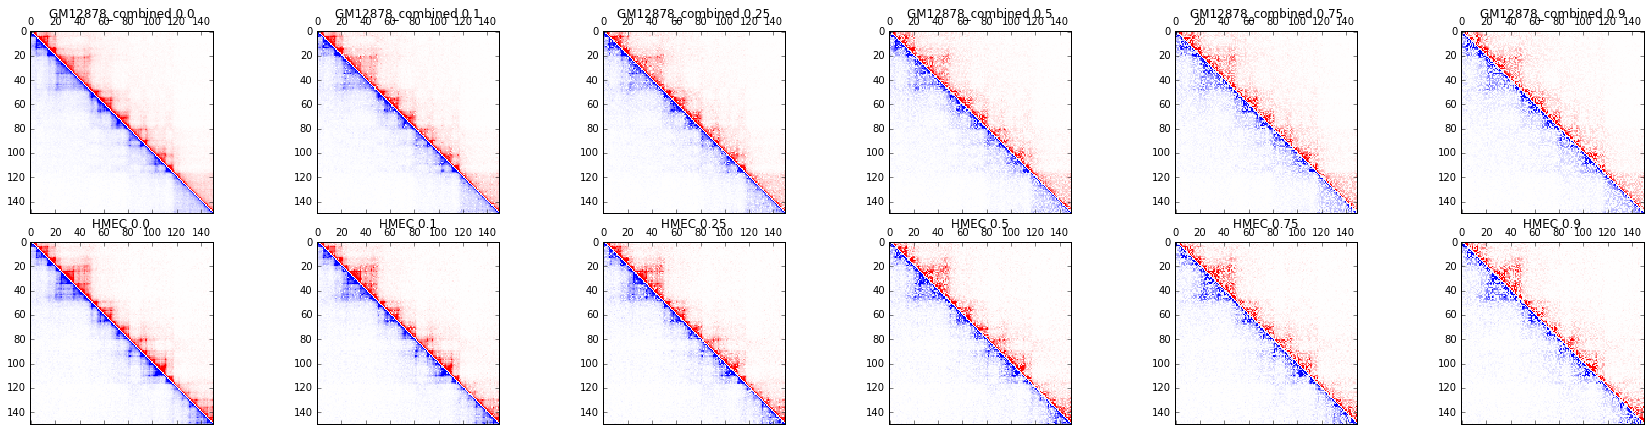

In [5]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

ms=['GM12878_combined','HMEC']
noises=[0.0,0.1,0.25,0.5,0.75,0.9]
ablist=['a','b']

data={}
for m_idx in range(len(ms)):
    mname=ms[m_idx]
    data[mname]={}
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        m1name=simdir+'/EdgeNoise/Depth_1000000.'+mname+'.EN_'+n+'.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'
        m2name=simdir+'/EdgeNoise/Depth_1000000.'+mname+'.EN_'+n+'.eps_0.9.NN_0.0.BN_0.b.dd_0.gz'
        m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
        m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
        m2=-m2.T
        m=m1+m2
        data[mname][n]=m
        

fig, plots = plt.subplots(nrows=len(ms), ncols=len(noises))
fig.set_size_inches(4*len(noises),len(ms)*3)
fig.tight_layout()

s=700
e=850

for m_idx in range(len(ms)):
    mname=ms[m_idx]
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        x=mquantiles(abs(data[mname][n]),0.999)
        plots[m_idx,noise_idx].matshow(data[mname][n][s:e,s:e],vmin=-x,vmax=x,cmap='bwr') #vmin=0,vmax=x,
        #plots[m_idx,noise_idx].axis('off')
        plots[m_idx,noise_idx].set_title(mname+' '+str(n))

Node noise
====

GenomeDISCO | Tue Jun 27 23:18:36 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:18:37 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:18:38 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.1.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:18:39 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.1.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:18:40 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_10

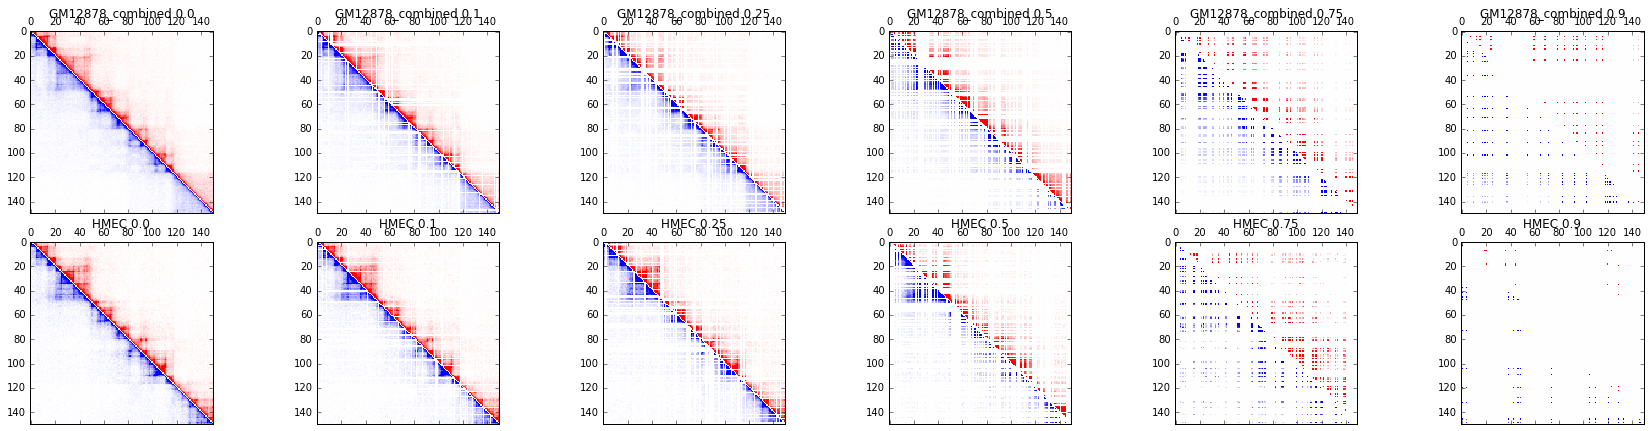

In [6]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

ms=['GM12878_combined','HMEC']
noises=[0.0,0.1,0.25,0.5,0.75,0.9]
ablist=['a','b']

data={}
for m_idx in range(len(ms)):
    mname=ms[m_idx]
    data[mname]={}
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        m1name=simdir+'/NodeNoise/Depth_1000000.'+mname+'.EN_0.0.eps_0.9.NN_'+n+'.BN_0.a.dd_0.gz'
        m2name=simdir+'/NodeNoise/Depth_1000000.'+mname+'.EN_0.0.eps_0.9.NN_'+n+'.BN_0.b.dd_0.gz'
        m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
        m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
        m2=-m2.T
        m=m1+m2
        data[mname][n]=m
        
fig, plots = plt.subplots(nrows=len(ms), ncols=len(noises))
fig.set_size_inches(4*len(noises),len(ms)*3)
fig.tight_layout()

s=700
e=850

for m_idx in range(len(ms)):
    mname=ms[m_idx]
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        x=mquantiles(abs(data[mname][n]),0.999)
        plots[m_idx,noise_idx].matshow(data[mname][n][s:e,s:e],vmin=-x,vmax=x,cmap='bwr') #vmin=0,vmax=x,
        #plots[m_idx,noise_idx].axis('off')
        plots[m_idx,noise_idx].set_title(mname+' '+str(n))

Boundary noise
===

GenomeDISCO | Tue Jun 27 23:20:38 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/BoundaryNoise/Depth_10000000.NHEK.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:20:39 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/BoundaryNoise/Depth_10000000.NHEK.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:20:40 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/BoundaryNoise/Depth_10000000.NHEK.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:20:41 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/BoundaryNoise/Depth_10000000.NHEK.EN_0.0.eps_0.9.NN_0.0.BN_8.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:20:42 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/BoundaryNoise/Depth_10000000.NHEK.EN_0.0.eps_0

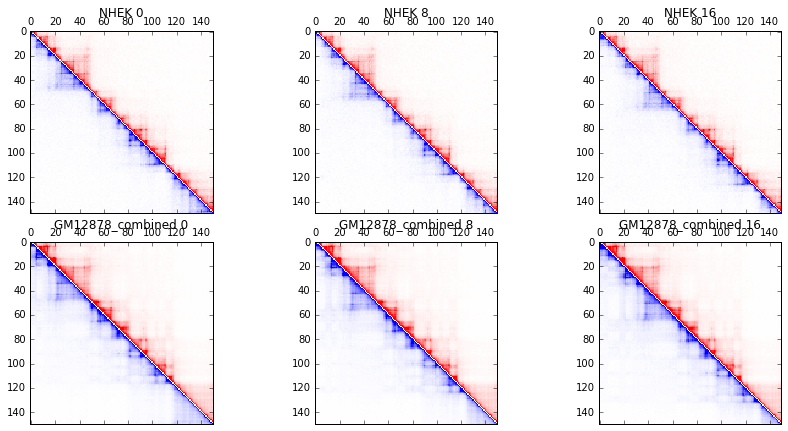

In [7]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

ms=['NHEK','GM12878_combined']#['GM12878_combined','HMEC','K562','KBM7','HUVEC','IMR90','NHEK']
noises=[0,8,16]
ablist=['a','b']

data={}
for m_idx in range(len(ms)):
    mname=ms[m_idx]
    data[mname]={}
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        m1name=simdir+'/BoundaryNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'
        m2name=simdir+'/BoundaryNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_'+n+'.b.dd_0.gz'
        m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
        m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
        m2=-m2.T
        m=m1+m2
        data[mname][n]=m
        
fig, plots = plt.subplots(nrows=len(ms), ncols=len(noises))
fig.set_size_inches(4*len(noises),len(ms)*3)
fig.tight_layout()

s=700
e=850

for m_idx in range(len(ms)):
    mname=ms[m_idx]
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        x=mquantiles(abs(data[mname][n]),0.999)
        plots[m_idx,noise_idx].matshow(data[mname][n][s:e,s:e],vmin=-x,vmax=x,cmap='bwr') #vmin=0,vmax=x,
        #plots[m_idx,noise_idx].axis('off')
        plots[m_idx,noise_idx].set_title(mname+' '+str(n))

Bioreps vs nonreps
====

GenomeDISCO | Tue Jun 27 23:25:35 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_10000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:25:37 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_10000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:25:38 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_10000000.HMEC.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz


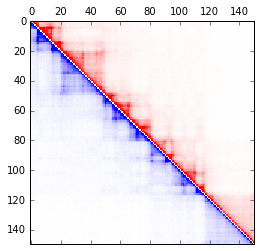

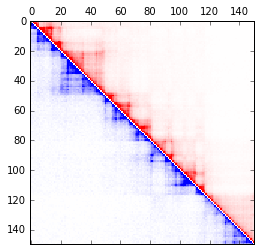

In [11]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

mname='GM12878_combined'
m1name=simdir+'/EdgeNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'
m2name=simdir+'/EdgeNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz'
mname='HMEC'
m3name=simdir+'/EdgeNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'

m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
m3=processing.construct_csr_matrix_from_data_and_nodes(m3name,nodes,True).toarray()

s=700
e=850

m2=-m2.T
m=m1+m2

x=mquantiles(abs(m),0.999)
plt.matshow(m[s:e,s:e],vmin=-x,vmax=x,cmap='bwr')
plt.show()

m3=-m3.T
m=m1+m3

x=mquantiles(abs(m),0.999)
plt.matshow(m[s:e,s:e],vmin=-x,vmax=x,cmap='bwr')
plt.show()


Sequencing depths
===

GenomeDISCO | Tue Jun 27 23:33:50 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_10000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:33:51 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_10000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz


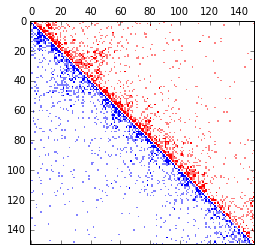

GenomeDISCO | Tue Jun 27 23:33:51 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_100000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:33:51 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_100000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz


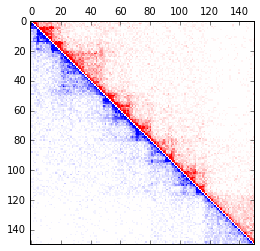

GenomeDISCO | Tue Jun 27 23:33:52 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:33:53 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/EdgeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz


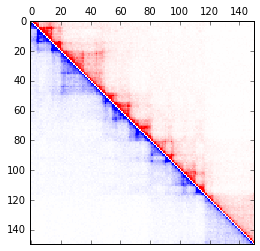

In [12]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

s=700
e=850

for depth in ['10000','100000','1000000']:
    mname='GM12878_combined'
    m1name=simdir+'/EdgeNoise/Depth_'+depth+'.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'
    m2name=simdir+'/EdgeNoise/Depth_'+depth+'.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz'
    m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
    m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()

    m2=-m2.T
    m=m1+m2

    x=mquantiles(abs(m),0.999)
    plt.matshow(m[s:e,s:e],vmin=-x,vmax=x,cmap='bwr')
    plt.show()

    


Distance dependence
===

GenomeDISCO | Tue Jun 27 23:44:32 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/DistanceDependence/Depth_10000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 23:44:33 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/DistanceDependence/Depth_10000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 23:44:35 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/DistanceDependence/Depth_10000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_1.gz


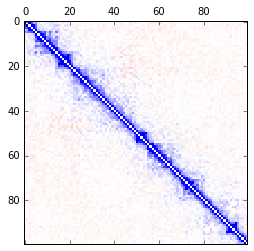

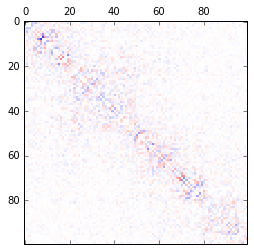

In [25]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

mname='GM12878_combined'
m1name=simdir+'/DistanceDependence/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'
m2name=simdir+'/DistanceDependence/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz'
m3name=simdir+'/DistanceDependence/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_1.gz'

m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
m1=m1+m1.T
m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
m2=m2+m2.T
m3=processing.construct_csr_matrix_from_data_and_nodes(m3name,nodes,True).toarray()
m3=m3+m3.T

s=700
e=800

#m3=-m3.T
m=m1-m3

x=mquantiles(abs(m),0.999)
plt.matshow(m[s:e,s:e],vmin=-x,vmax=x,cmap='bwr')
plt.show()

#m2=-m2.T
m=m1-m2

plt.matshow(m[s:e,s:e],vmin=-x,vmax=x,cmap='bwr')
plt.show()



In [7]:
#compute distance curves for every dataset we have, to find 2 different ones
nodefile='/ifs/scratch/oursu/data/chr21_datasets/nodes.50000.chr21.gz'
nodes,nodes_idx=processing.read_nodes_from_bed(nodefile)

ms=['GM12878_combined','HMEC','K562','KBM7','HUVEC','IMR90','NHEK']
mdata={}
dd={}
for mname in ms:
    mfile='/ifs/scratch/oursu/data/chr21_datasets/'+mname+'.chr21.RAWobserved.gz'
    mdata[mname]=processing.construct_csr_matrix_from_data_and_nodes(mfile,nodes,True)
    dd[mname]=data_operations.get_distance_dep(mdata[mname])

GenomeDISCO | Mon Jun 26 18:33:38 2017 | processing: Loading genomic regions from /ifs/scratch/oursu/data/chr21_datasets/nodes.50000.chr21.gz
num nodes
963
GenomeDISCO | Mon Jun 26 18:33:38 2017 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/GM12878_combined.chr21.RAWobserved.gz
GenomeDISCO | Mon Jun 26 18:33:58 2017 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/HMEC.chr21.RAWobserved.gz
GenomeDISCO | Mon Jun 26 18:34:08 2017 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/K562.chr21.RAWobserved.gz
GenomeDISCO | Mon Jun 26 18:34:26 2017 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/KBM7.chr21.RAWobserved.gz
GenomeDISCO | Mon Jun 26 18:34:41 2017 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/HUVEC.chr21.RAWobserved.gz
GenomeDISCO | Mon Jun 26 18:34:57 2017 | processing: Loading interaction data from /ifs/scr

In [9]:
def get_dd_diff(m1dd,m2dd):
    d=0.0
    k=set(m1dd.keys()).union(set(m2dd.keys()))
    for key in k:
        if key in m1dd:
            m1val=m1dd[key]
        else:
            m1val=0.0
        if key in m2dd:
            m2val=m2dd[key]
        else:
            m2val=0.0
        d+=abs(m1val-m2val)
    return d

for mname1 in ms:
    for mname2 in ms:
        print mname1+'.'+mname2
        print get_dd_diff(dd[mname1],dd[mname2])

GM12878_combined.GM12878_combined
0.0
GM12878_combined.HMEC
0.000177937124952
GM12878_combined.K562
0.000110076797825
GM12878_combined.KBM7
0.000183982446919
GM12878_combined.HUVEC
9.55576934733e-05
GM12878_combined.IMR90
9.33094920298e-05
GM12878_combined.NHEK
0.000149811081728
HMEC.GM12878_combined
0.000177937124952
HMEC.HMEC
0.0
HMEC.K562
9.9854901856e-05
HMEC.KBM7
0.000180074001393
HMEC.HUVEC
0.000254053206916
HMEC.IMR90
0.000108543777412
HMEC.NHEK
4.64523902334e-05
K562.GM12878_combined
0.000110076797825
K562.HMEC
9.9854901856e-05
K562.K562
0.0
K562.KBM7
0.000112123737836
K562.HUVEC
0.000176880605622
K562.IMR90
0.000116632294893
K562.NHEK
6.98557720586e-05
KBM7.GM12878_combined
0.000183982446919
KBM7.HMEC
0.000180074001393
KBM7.K562
0.000112123737836
KBM7.KBM7
0.0
KBM7.HUVEC
0.000195334192974
KBM7.IMR90
0.000200440392343
KBM7.NHEK
0.000150549291942
HUVEC.GM12878_combined
9.55576934733e-05
HUVEC.HMEC
0.000254053206916
HUVEC.K562
0.000176880605622
HUVEC.KBM7
0.000195334192974
HUVEC.

In [71]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

ms=['GM12878_combined','HMEC']
noises=[0.0,0.1,0.25,0.5,0.75,0.9]
ablist=['a','b']

data={}
for m_idx in range(len(ms)):
    mname=ms[m_idx]
    data[mname]={}
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        m1name=simdir+'/NodeNoise/Depth_1000000.'+mname+'.EN_0.0.eps_0.9.NN_'+n+'.BN_0.a.dd_0.gz'
        m2name=simdir+'/NodeNoise/Depth_1000000.'+mname+'.EN_0.0.eps_0.9.NN_'+n+'.BN_0.b.dd_0.gz'
        m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
        m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
        m2=-m2.T
        m=m1+m2
        data[mname][n]=m

GenomeDISCO | Tue Jun 27 02:21:09 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 02:21:11 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.0.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 02:21:11 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.1.BN_0.a.dd_0.gz
GenomeDISCO | Tue Jun 27 02:21:12 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_1000000.GM12878_combined.EN_0.0.eps_0.9.NN_0.1.BN_0.b.dd_0.gz
GenomeDISCO | Tue Jun 27 02:21:13 2017 | processing: Loading interaction data from /ifs/scratch/oursu/3d/paper/2017-06-08/simulations/NodeNoise/Depth_10

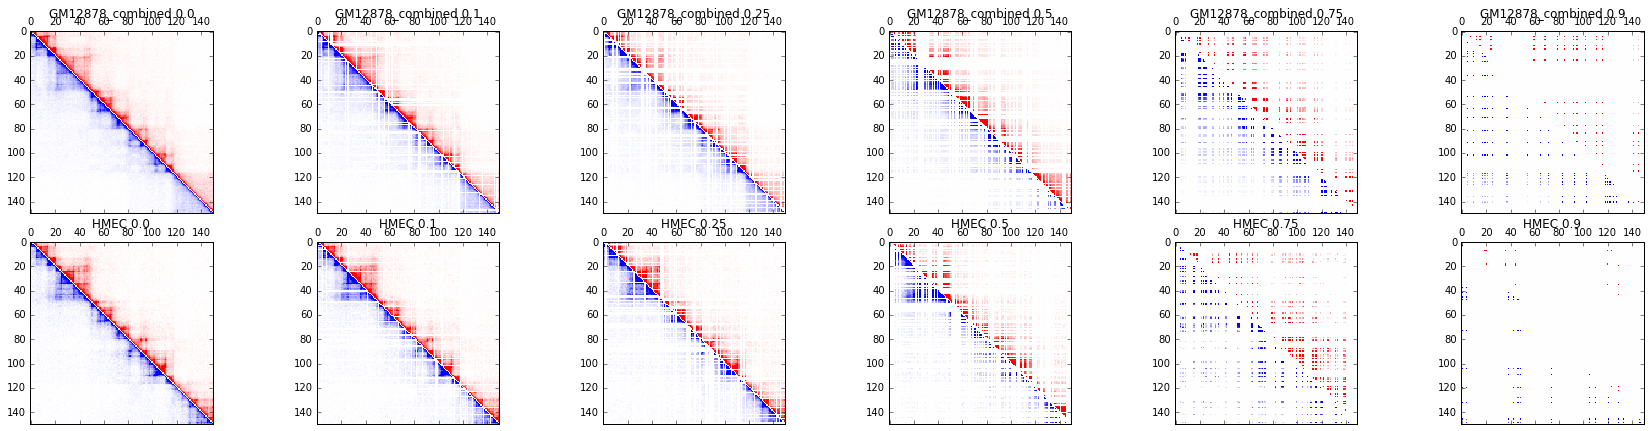

In [72]:
fig, plots = plt.subplots(nrows=len(ms), ncols=len(noises))
fig.set_size_inches(4*len(noises),len(ms)*3)
fig.tight_layout()

s=700
e=850

for m_idx in range(len(ms)):
    mname=ms[m_idx]
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        x=mquantiles(abs(data[mname][n]),0.999)
        plots[m_idx,noise_idx].matshow(data[mname][n][s:e,s:e],vmin=-x,vmax=x,cmap='bwr') #vmin=0,vmax=x,
        #plots[m_idx,noise_idx].axis('off')
        plots[m_idx,noise_idx].set_title(mname+' '+str(n))

In [ ]:
simdir='/ifs/scratch/oursu/3d/paper/2017-06-08/simulations'

ms=['NHEK','GM12878_combined']#['GM12878_combined','HMEC','K562','KBM7','HUVEC','IMR90','NHEK']
noises=[0,8,16]
ablist=['a','b']

data={}
for m_idx in range(len(ms)):
    mname=ms[m_idx]
    data[mname]={}
    for noise_idx in range(len(noises)):
        n=str(noises[noise_idx])
        m1name=simdir+'/BoundaryNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_0.a.dd_0.gz'
        m2name=simdir+'/BoundaryNoise/Depth_10000000.'+mname+'.EN_0.0.eps_0.9.NN_0.0.BN_'+n+'.b.dd_0.gz'
        m1=processing.construct_csr_matrix_from_data_and_nodes(m1name,nodes,True).toarray()
        m2=processing.construct_csr_matrix_from_data_and_nodes(m2name,nodes,True).toarray()
        m2=-m2.T
        m=m1+m2
        data[mname][n]=m